In [1]:
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import models
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [3]:
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

full_dataset = datasets.ImageFolder(root='data2')

train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size 

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size])

train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = val_test_transforms
test_dataset.dataset.transform = val_test_transforms

batch_size = 64 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [ ]:
resnet18 = models.resnet18(pretrained=True)
num_input_channels = 3 
resnet18.conv1 = torch.nn.Conv2d(num_input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
resnet18.fc = torch.nn.Linear(resnet18.fc.in_features, 3)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:

def train(model, train_loader, val_loader, optimizer, criterion, num_epochs=10):
    model.to(device)
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    for epoch in range(num_epochs):
        model.train()

        training_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            training_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = training_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        val_results = validate(model, val_loader, criterion)
        val_losses.append(val_results[5])  # Make sure this is correctly indexing the average loss
        val_accuracies.append(val_results[0])
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Training Acc: {epoch_acc:.4f}, Val Acc: {val_results[0]:.4f}, Val Loss: {val_results[5]:.4f}')

    torch.save(model.state_dict(), 'resnet18_model.pth')
    return (train_losses, val_losses, train_accuracies, val_accuracies)

def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss += criterion(val_outputs, val_labels).item() * val_images.size(0)
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

            y_true.extend(val_labels.cpu().numpy())
            y_pred.extend(val_predicted.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)

    val_loss /= val_total

    return [accuracy, precision, recall, f1, cm, val_loss]

Epoch 1/6, Loss: 0.1799, Training Acc: 0.9378, Val Acc: 0.8618, Val Loss: 0.4260
Epoch 2/6, Loss: 0.1463, Training Acc: 0.9469, Val Acc: 0.8954, Val Loss: 0.3313
Epoch 3/6, Loss: 0.1170, Training Acc: 0.9546, Val Acc: 0.9103, Val Loss: 0.2752
Epoch 4/6, Loss: 0.0668, Training Acc: 0.9765, Val Acc: 0.8929, Val Loss: 0.3386
Epoch 5/6, Loss: 0.0814, Training Acc: 0.9707, Val Acc: 0.8306, Val Loss: 0.5780
Epoch 6/6, Loss: 0.0733, Training Acc: 0.9744, Val Acc: 0.8892, Val Loss: 0.4156


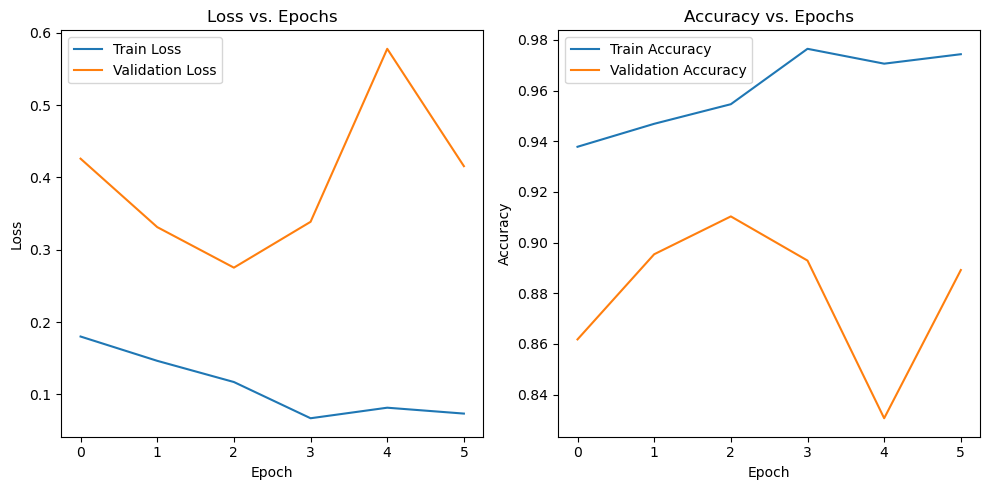

In [19]:
num_epochs = 6
train_losses, val_losses, train_accuracies, val_accuracies = train(resnet18, train_loader, val_loader, optimizer, criterion, num_epochs=num_epochs)

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [115]:
def plot_confusion_matrix(cm):
    class_labels = full_dataset.classes

    plt.figure(figsize=(8, 6))
    sns.set_theme(font_scale=1.2)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Testing set accuracy:  0.9072398190045249
884


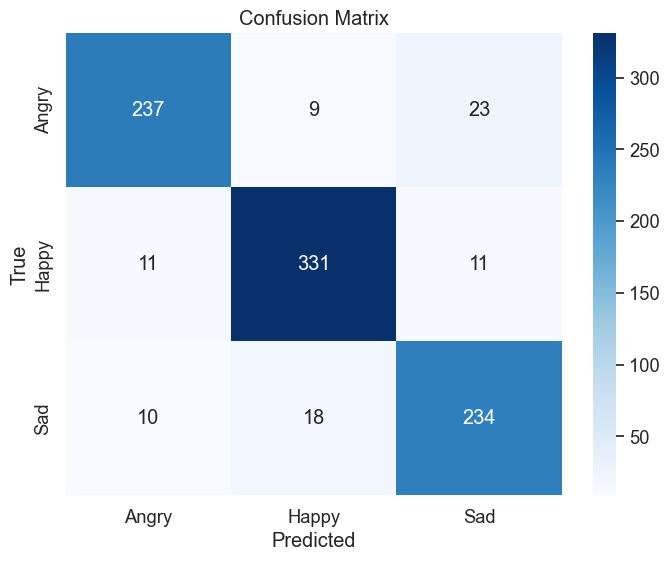

In [116]:
# Run on test dataset
results = validate(resnet18, test_loader, criterion)
print('Testing set accuracy: ', results[0])
print(len(test_dataset))
plot_confusion_matrix(results[4])

In [ ]:
torch.save(resnet18.state_dict())

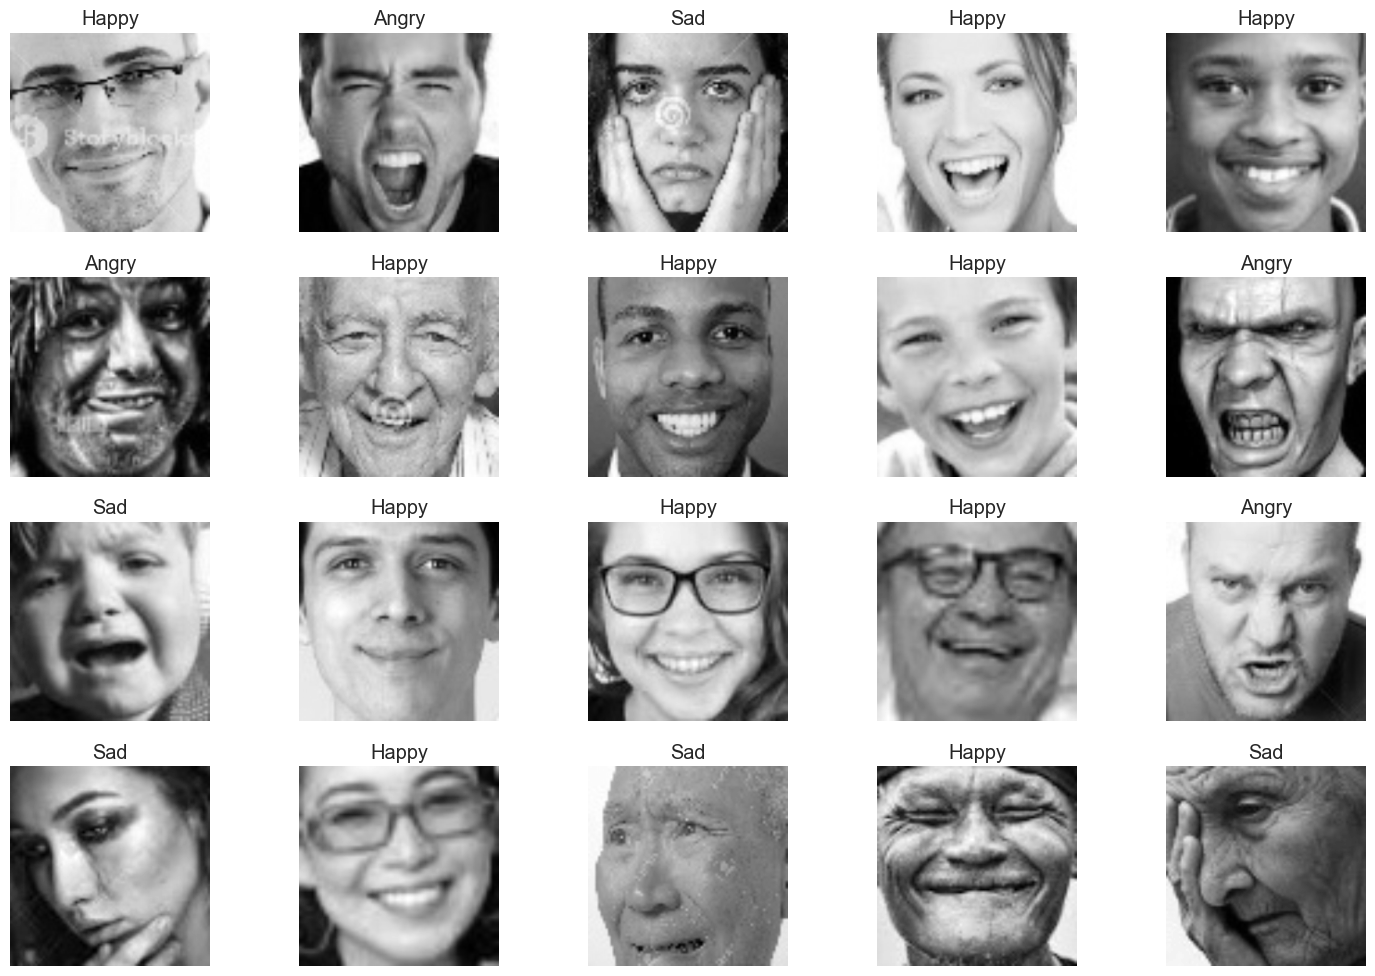

Correctly classified:  19


In [154]:
# Test for a random 20 samples and plot from the test dataset

import random
import cv2
class_names = full_dataset.classes

random_indices = random.sample(range(len(test_dataset)), 20)

sample_images = []
predicted_emotions = []
count = 0

for idx in random_indices:
    image, label = test_dataset[idx]
    predicted_label = resnet18(image.unsqueeze(0)).argmax().item()
    predicted_emotion = class_names[predicted_label]
    if predicted_label == label:
        count += 1
    sample_images.append(image)
    predicted_emotions.append(predicted_emotion)

plt.figure(figsize=(15, 10))
for i in range(len(sample_images)):
    plt.subplot(4, 5, i + 1)
    image = sample_images[i].numpy().transpose(1, 2, 0)

    if image.shape[2] == 3:
        image = 0.2989 * image[:,:,0] + 0.5870 * image[:,:,1] + 0.1140 * image[:,:,2]

    plt.imshow(image, cmap='gray')
    plt.title(predicted_emotions[i])
    plt.axis('off')
plt.tight_layout()
plt.show()
print('Correctly classified: ', count)


In [24]:
import mtcnn
face_detector = mtcnn.MTCNN()

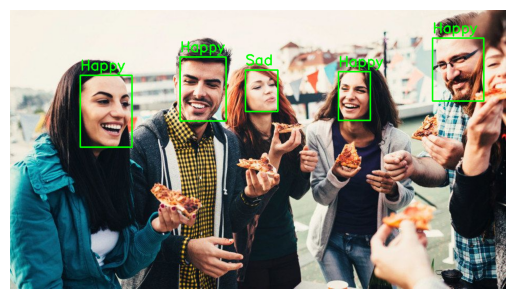

In [130]:
# Test on old datset image
import cv2
from PIL import Image

resnet18.eval()

image_path = '/Users/davinci/Desktop/dhanush/projects/emotion_recognition/data/Happy/56f455011e0000b300705475.jpeg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

faces = face_detector.detect_faces(image)

for face in faces:
    (x, y, w, h) = face['box']
    if face['confidence'] < 0.9:
        continue
    face_roi = image[y:y+h, x:x+w]
    face_roi = Image.fromarray(face_roi)
    
    input_image = val_test_transforms(face_roi)
    input_image = input_image.unsqueeze(0)

    with torch.no_grad():
        output = resnet18(input_image)
    predicted_label = output.argmax().item()
    predicted_emotion = class_names[predicted_label]

    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.putText(image, f'{predicted_emotion}', (x, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

plt.imshow(image)
plt.axis('off')
plt.show()


In [ ]:
state_dict = torch.load('best_model.pth')
model = models.resnet18(pretrained=True)
model.load_state_dict(state_dict)

model.eval()

In [ ]:
# Live video recognition
cap = cv2.VideoCapture(0)
class_names = full_dataset.classes

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
cv2.waitKey(1000)

while cap.isOpened():
    ret, frame = cap.read() 
    if not ret:
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    # faces = face_detector.detect_faces(frame)

    for (x,y,w,h) in faces:
    # for face in faces:
    #     (x, y, w, h) = face['box']
        # if face['confidence'] < 0.9:
        #     continue
        face_roi = frame[y:y+h, x:x+w]

        face_img = val_test_transforms(face_roi)
        input_tensor = face_img.unsqueeze(0)

        with torch.no_grad():
            output = resnet18(input_tensor)

        predicted_index = torch.argmax(output, dim=1).item()
        predicted_class = class_names[predicted_index]

        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(frame, f'Emotion: {predicted_class}', (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    cv2.imshow('Live Emotion Detection', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()

cv2.destroyAllWindows()

In [118]:
conv_weights = []
conv_layers = [] 
total_conv_layers = 0

for module in resnet18.children():
	if isinstance(module, nn.Conv2d):
		total_conv_layers += 1
		conv_weights.append(module.weight)
		conv_layers.append(module)


Total convolution layers: 1


In [ ]:
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pretrained_model = resnet18.to(device)
image_path = '/Users/davinci/Desktop/dhanush/projects/emotion_recognition/data_clean/Angry/118-1183761_angry-person-transparent-images-png-angry-man-png.png'

image = Image.open(image_path)

input_image = val_test_transforms(image)
input_image = input_image.unsqueeze(0)
input_image = input_image.to(device)

feature_maps = []
layer_names = []
for layer in conv_layers:
	input_image = layer(input_image)
	feature_maps.append(input_image)
	layer_names.append(str(layer))

print("\nFeature maps shape")
for feature_map in feature_maps:
	print(feature_map.shape)

processed_feature_maps = []
for feature_map in feature_maps:
	feature_map = feature_map.squeeze(0)
	mean_feature_map = torch.sum(feature_map, 0) / feature_map.shape[0]
	processed_feature_maps.append(mean_feature_map.data.cpu().numpy())

print("\n Processed feature maps shape")
for fm in processed_feature_maps:
	print(fm.shape)

fig = plt.figure(figsize=(30, 50))
for i in range(len(processed_feature_maps)):
	ax = fig.add_subplot(5, 4, i + 1)
	ax.imshow(processed_feature_maps[i])
	ax.axis("off")
	ax.set_title(layer_names[i].split('(')[0], fontsize=30)


In [26]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np

def get_grad_cam(model, image, target_layer):
    
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(image).unsqueeze(0)
    input_tensor.requires_grad = True

    model.eval()
    activations = {}
    def save_activation(name):
        def hook(model, input, output):
            activations[name] = output
        return hook

    hook_handle = target_layer.register_forward_hook(save_activation('target'))

    output = model(input_tensor)

    hook_handle.remove()

    target_activations = activations['target']
    if not target_activations.requires_grad:
        raise RuntimeError("No gradients computed for target activations")

    gradients = torch.autograd.grad(outputs=target_activations.sum(), inputs=input_tensor,
                                    create_graph=True)[0]

    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    target_activations = target_activations[0] 
    for i in range(gradients.shape[1]):
        target_activations[i, :, :] *= pooled_gradients[i]

    grad_cam = torch.nn.functional.relu(target_activations.sum(dim=0)).detach()
    grad_cam = torch.nn.functional.interpolate(grad_cam.unsqueeze(0).unsqueeze(0), 
                                               size=(224, 224), mode='bilinear', align_corners=False)
    grad_cam = grad_cam.squeeze().numpy()

    return grad_cam


[6, 0, 67, 76]


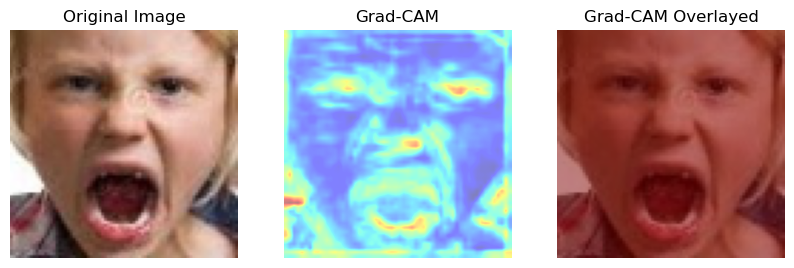

In [33]:
# Trying to visualize feature heatmaps (WIP)
import cv2

target_layer = resnet18.layer1

image_path = 'data2/Angry/anger3 copy.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
faces = face_detector.detect_faces(image)

for face in faces:
    (x, y, w, h) = face['box']
    print(face['box'])
    if face['confidence'] < 0.9:
        continue
    face_roi = image[y:y+h, x:x+w]
    face_roi = Image.fromarray(face_roi)
    grad_cam = get_grad_cam(resnet18, face_roi, target_layer)
    break

original_image = Image.open(image_path)

plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(grad_cam, cmap='jet', alpha=0.5)
plt.title('Grad-CAM')
plt.axis('off')

grad_cam_colored = plt.get_cmap('jet')(grad_cam)[:, :, :3]
grad_cam_colored = (grad_cam_colored * 255).astype(np.uint8)
grad_cam_image = Image.fromarray(grad_cam_colored)

grad_cam_image = grad_cam_image.resize(original_image.size, Image.LANCZOS)

original_image_rgba = original_image.convert('RGBA')
grad_cam_image_rgba = grad_cam_image.convert('RGBA')

blended_image = Image.blend(original_image_rgba, grad_cam_image_rgba, alpha=0.5)

plt.subplot(1, 3, 3)
plt.imshow(blended_image)
plt.title('Grad-CAM Overlayed')
plt.axis('off')

plt.show()

[4, 0, 68, 76]


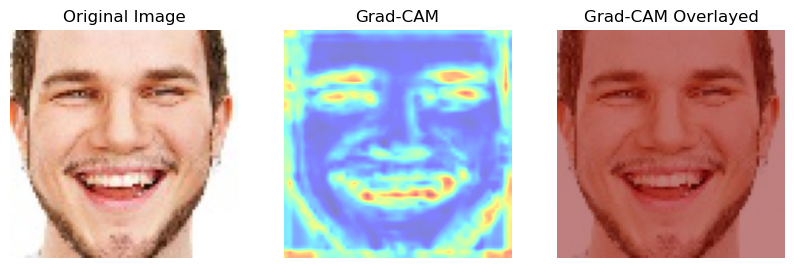

In [34]:
# Trying to visualize feature heatmaps (WIP)
import cv2

target_layer = resnet18.layer1

image_path = "data2/Happy/happiness34 copy.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
faces = face_detector.detect_faces(image)

for face in faces:
    (x, y, w, h) = face['box']
    print(face['box'])
    if face['confidence'] < 0.9:
        continue
    face_roi = image[y:y+h, x:x+w]
    face_roi = Image.fromarray(face_roi)
    grad_cam = get_grad_cam(resnet18, face_roi, target_layer)
    break

original_image = Image.open(image_path)

plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(grad_cam, cmap='jet', alpha=0.5)
plt.title('Grad-CAM')
plt.axis('off')

grad_cam_colored = plt.get_cmap('jet')(grad_cam)[:, :, :3]
grad_cam_colored = (grad_cam_colored * 255).astype(np.uint8)
grad_cam_image = Image.fromarray(grad_cam_colored)

grad_cam_image = grad_cam_image.resize(original_image.size, Image.LANCZOS)

original_image_rgba = original_image.convert('RGBA')
grad_cam_image_rgba = grad_cam_image.convert('RGBA')

blended_image = Image.blend(original_image_rgba, grad_cam_image_rgba, alpha=0.5)

plt.subplot(1, 3, 3)
plt.imshow(blended_image)
plt.title('Grad-CAM Overlayed')
plt.axis('off')

plt.show()